In [1]:
import os
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import linear_model
from tqdm import tqdm
from scipy.stats import norm
import statistics
from ast import literal_eval
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA


In [2]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import copy
import warnings
import pandas as pd
import copy
from sklearn.neural_network import MLPRegressor

In [3]:
#pd.set_option('max_columns', 330)
#pd.set_option('max_rows', 100)

In [4]:
%matplotlib inline
# plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Load dataframes

In [5]:
input_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Ner thesis//'
df = pd.read_excel(input_path+'data.xlsx', index_col=0)
df = df.resample('M', label='right').mean()
df

,Aluminium (USD/tonne),Copper (USD/pound),Zinc (USD/tonne),Nickel (USD/MT),Lead (USD/tonne),Tin (USD/tonne),Silver (USD/ t oz),Gold (USD/ t oz),Crude Oil WTI (USD/ bbl),Crude oil Brent (USD/bbl),Natural gas (USD/Mmbtu),USD index,DJIA (USD),FTSE 100 (GBP),Hang seng (HKD),US libor
Date,,,,,,,,,,,,,,,,
1995-01-31,2060.365000,1.400250,1156.515000,9605.200000,665.875000,6194.750000,4.753800,378.585000,17.973500,16.553000,1.430350,88.151500,3873.884000,3030.105000,7454.471000,6.339500
1995-02-28,1893.213333,1.340267,1022.873333,8360.866667,575.740000,5420.533333,4.702267,376.926667,18.545333,17.070000,1.438600,87.368667,3959.192667,3060.286667,7989.160000,6.260667
1995-03-31,1802.627273,1.390091,1023.109091,7536.363636,584.336364,5536.590909,4.658955,382.454545,18.574545,16.916818,1.535455,83.746818,4063.885000,3079.659091,8370.944545,6.268636
1995-04-30,1851.800000,1.335882,1062.082353,7403.882353,607.876471,5866.411765,5.533294,391.105882,19.916471,18.420588,1.660941,81.663529,4234.504118,3198.858824,8501.802353,6.235882
1995-05-31,1767.871429,1.281095,1036.171429,7275.476190,596.352381,5926.714286,5.512095,385.571429,19.714286,18.388571,1.709762,82.672381,4391.934286,3288.314286,8935.610476,6.127619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,1748.559524,2.661929,2279.916667,15748.642857,2044.547619,16587.023810,17.217476,1503.085714,54.901429,59.540000,2.171619,97.999381,26065.815238,7203.483333,26001.722381,2.164805
2019-09-30,1764.162500,2.687475,2320.125000,17633.825000,2074.862500,16842.875000,18.142100,1509.445000,56.967000,62.468500,2.519550,98.594250,26900.214000,7321.854000,26516.656000,2.124800
2019-10-31,1733.214286,2.692143,2425.654762,16991.380952,2188.416667,16663.571429,17.691190,1495.980952,54.083810,59.728571,2.345462,98.082948,26756.916667,7215.755714,26458.149524,1.970481


In [6]:
df.isnull().sum()

Aluminium (USD/tonne)        0
Copper (USD/pound)           0
Zinc (USD/tonne)             0
Nickel (USD/MT)              0
Lead (USD/tonne)             0
Tin (USD/tonne)              0
Silver (USD/ t oz)           0
Gold (USD/ t oz)             0
Crude Oil WTI (USD/ bbl)     0
Crude oil Brent (USD/bbl)    0
Natural gas (USD/Mmbtu)      0
USD index                    0
DJIA (USD)                   0
 FTSE 100 (GBP)              0
Hang seng (HKD)              0
 US libor                    0
dtype: int64

### create lagged df

In [7]:
def lagged_df_func(df, target_variable, min_lag=1, max_lag=90):
    '''Create a dataframe with variables that are lagged between a minimum and maximum lag
    Arg1: datafarme produced as output of exploratory data analysis functions
    Arg2: variable for the analysis
    Arg2: minimum lag for each variable
    Arg3: Maximum lag for each variable
    Returns: Pandas dataframe with variables lagged between minimum and maximum lag
    '''
    df = df.reset_index()  # .drop(columns='index')
    feature_list = list(df.columns)
#     feature_list.remove('month')
    feature_list.remove('Date')

    lagged_df = pd.DataFrame()

    for variable in feature_list:
        for i in range(min_lag, max_lag + 1):
            col2 = df[variable].shift(i)
            lagged_df[variable + '_' + str(i)] = col2

    lagged_df['Date'] = df['Date']
#     lagged_df['month'] = df['month']
    lagged_df[target_variable] = df[target_variable]
    if target_variable+'_0' in lagged_df.columns:
        lagged_df = lagged_df.drop(columns=['malaria_prev_0'])
    lagged_df.set_index('Date', inplace=True)
    
    return(lagged_df)

# 1. Univariate analysis

First define functions

In [8]:
# results_path = r'C:\Users\atorolopoulos\Desktop\Python\Results\ML Multivariate'

def plot_model_performance(lagged_df, results, y_test, target_var, results_path):
    plt.figure(figsize=(20, 20))

    plt.plot(lagged_df.index[results['lead_time']:results['test_break']+results['lead_time']],
             lagged_df[target_var][results['lead_time']:results['test_break']+results['lead_time']], 'b')
    plt.plot(results['predicted dates'], y_test, 'b', label='observed')
    plt.plot(results['predicted dates'], results['central_prediction'], 'y', label='central prediction')
#     plt.plot(results['predicted dates'], results['upper_bound'], 'r', label='upper prediction')
#     plt.plot(results['predicted dates'], results['lower_bound'], 'r', label='lower prediction')
    conf = results['confidence_interval']
#     plt.fill_between(results['predicted dates'], results['lower_bound'], results['upper_bound'],
#                      color='r', alpha=0.05, label=f'{conf:.0f}% confidence interval')
    
    plt.rcParams['font.size'] = '16'
    plt.legend()
    plt.xlabel('dates')
    plt.ylabel(target_var)
    mt = results['model_type']
    lt = results['lead_time']
    title = f'{mt} with lead time {lt} and confidence interval {conf:.0f}% performance'
    plt.title(title)
    plt.grid()
    plt.savefig(results_path+title)
    plt.show();

def zoomed_model_performance(results, y_test, target_var, results_path):
    # plot
    plt.figure(figsize=(12, 12))

    plt.plot(results['predicted dates'], y_test, 'b', label='observed')
    plt.plot(results['predicted dates'], results['central_prediction'], 'y', label='central prediction')
    plt.plot(results['predicted dates'], results['upper_bound'], 'r', label='upper prediction')
    plt.plot(results['predicted dates'], results['lower_bound'], 'r', label='lower prediction')
    conf = results['confidence_interval']
    plt.fill_between(results['predicted dates'], results['lower_bound'], results['upper_bound'],
                     color='r', alpha=0.05, label=f'{conf:.0f}% confidence interval')

    plt.rcParams['font.size'] = '16'
    plt.legend()
    plt.xlabel('dates')
    plt.ylabel(target_var)
    mt = results['model_type']
    lt = results['lead_time']
    title = f'{mt} with lead time {lt} and confidence interval {conf:.0f}% performance'
    plt.title(title)
    plt.grid()
    plt.savefig(results_path + title)
    plt.show();

def model_run(lagged_df, model_type, best_vars, lead_time, target_var, confidence=0.9, boot=1000, test_ratio=0.1):
    model_dict = {'MLPRegressor()': MLPRegressor(), 'XGBRegressor()': XGBRegressor(),
                  'RandomForestRegressor()': RandomForestRegressor(),
                  'LinearRegression()': linear_model.LinearRegression(), 'Ridge()': linear_model.Ridge(),
                  'SVR()': svm.SVR(), 'KNeighborsRegressor()': KNeighborsRegressor()}

    model_df = lagged_df.copy()
    mod = model_dict[model_type]
    lagged_df = lagged_df[best_vars + [target_var]]  # get rid of not usefull variables

    # create test dataset, if we want to test on the last values
    test_break = int(len(lagged_df) * (1 - test_ratio))
    X_train = lagged_df.drop(columns=target_var).to_numpy()[:test_break]
    y_train = lagged_df[target_var].to_numpy()[:test_break]
    X_test = lagged_df.drop(columns=target_var).to_numpy()[test_break:]
    y_test = lagged_df[target_var].to_numpy()[test_break:]
    pred_date = lagged_df.index[test_break:]  # lead time already added  + pd.DateOffset(months=lead_time)
    pred_date = pred_date.to_numpy()

    # train model
    scalar = StandardScaler()
    scalar.fit_transform(X_train)
    scalar.transform(X_test)


    # make predictions for test data
    predictions = -9999 * np.ones((boot, len(y_test)))
    temp_lagged_df = lagged_df[:test_break]  # training values to be used for bootstrapping

    for j in range(boot):
        bootstrap_df = lagged_df.sample(int(len(temp_lagged_df) * 0.8), replace=True)

        bs_X_train = bootstrap_df.drop(columns=target_var)
        bs_y_train = bootstrap_df[target_var]

#         scalar = StandardScaler()
        scalar.transform(bs_X_train)

        mod.fit(bs_X_train, bs_y_train)

        y_pred = mod.predict(X_test)
        predictions[j, :] = y_pred

    upper = -9999 * np.ones(len(y_test))
    mean = -9999 * np.ones(len(y_test))
    lower = -9999 * np.ones(len(y_test))

    for j in range(len(y_test)):
        pred = predictions[:, j]
        pred = np.sort(pred)

        lower[j] = pred[int(len(pred) * ((1 - confidence) / 2))]
        mean[j] = pred[int(len(pred) * 0.5)]
        upper[j] = pred[int(len(pred) * (1 - ((1 - confidence) / 2)))]


    # log to raw
#     predictions = np.exp(predictions)
#     y_test = np.exp(y_test)
#     lower = np.exp(lower)
#     mean = np.exp(mean)
#     upper = np.exp(upper)
    
    # evaluate predictions
    rmse = np.sqrt(mean_squared_error(y_test, mean))
    coefficient_of_dermination = r2_score(y_test, mean)
    emse = np.mean(y_test**2 - mean**2)
    mae = np.mean(y_test - mean)
    mape = np.mean(np.abs((y_test - mean)/y_test))*100  # %
    nse = 1-(np.sum((mean-y_test)**2)/np.sum((y_test-np.mean(y_test))**2))

    results_dict = {'model_type': model_type, 'lead_time': int(lead_time), 'root mean squared error': rmse,
                    'MAE':mae, 'MAPE [%]':mape, 'R2:': coefficient_of_dermination, 'expected mean squared error': emse, 
                    'NSE':nse, 'test_break': test_break, 'confidence_interval': confidence * 100, 
                    'predicted dates': pred_date, 'lower_bound': lower, 'central_prediction': mean, 'upper_bound': upper,
                    'test_ratio': test_ratio * 100}

    return(results_dict, predictions, y_test)

In [59]:
def corr_target(df, target_variable, title, results_path):
    '''correlation of individual features 
    Return: sorted dataframe with all the correlations 
    '''

    corrmat = df.corr()
    corrmat = corrmat[target_variable]
    corrmat = corrmat.iloc[:-1]
    corrmat = corrmat.sort_values(ascending=False, key=abs)
    corrmat = pd.DataFrame(data=corrmat, columns=[target_variable])
    corrmat.reset_index(inplace=True)
    corrmat.rename({'index': 'feature'}, axis=1, inplace=True)

    corrmat.to_excel(results_path + title, index=False)

    return (corrmat)

def choose_best_vars(lagged_df, lead_times, target_variable, results_path, thr = 0.01):
    best_vars = []

    for lead_time in lead_times:
        title = f'Sorted correlations for {target_var[:4]} for lead time {lead_time}.xlsx'
#         if lead_time==1:
#             df_corr = corr_target(lagged_df, target_variable, title, results_path)
#         else:
#             temp_lagged_df = copy.deepcopy(lagged_df)
#             temp_lagged_df[target_variable] = lagged_df[target_variable].shift(-lead_time+1)
#             temp_lagged_df.dropna(inplace=True)
#             df_corr = corr_target(temp_lagged_df, target_variable, title, results_path)
        df_corr = corr_target(lagged_df, target_variable, title, results_path)
        df_corr = df_corr[ df_corr[target_variable] > thr ]
#         print(lead_time, df_corr)
        bv = df_corr.feature.to_list()

        best_vars.append(bv)
#     print(best_vars[6])
    for j, lead_time in enumerate(lead_times):
        best_vars[j] = [ x for x in best_vars[j] if not int(x.split('_')[1]) < lead_time]
#         for i in range(1, lead_time, 1):  # get rid of wrong time steps
#             substring = '_'+str(i)
#             best_vars[j] = [ x for x in best_vars[j] if int(x.split('_')[1]) <= lead_time]
#             best_vars[j] = [ x for x in best_vars[j] if int(x.split('_')[1])x[-len(substring):] is substring ]
#         print(best_vars[j])
    return best_vars

### 1. target variable is 'Aluminium (USD/tonne)'

ML models

In [10]:
target_var = 'Aluminium (USD/tonne)'

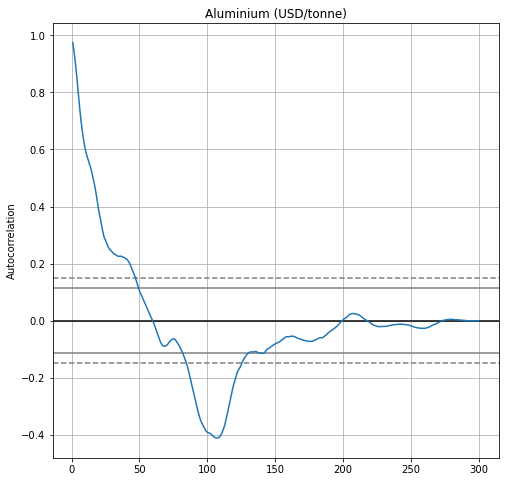

In [11]:
# define subplot grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pd.plotting.autocorrelation_plot(df[target_var], ax=ax)
# chart formatting
ax.set_title(target_var)
ax.set_xlabel("")
plt.show();

In [12]:
lagged_df = lagged_df_func(df, target_var, min_lag=1, max_lag=50)
lagged_df.dropna(inplace=True)
lagged_df

,Aluminium (USD/tonne)_1,Aluminium (USD/tonne)_2,Aluminium (USD/tonne)_3,Aluminium (USD/tonne)_4,Aluminium (USD/tonne)_5,Aluminium (USD/tonne)_6,Aluminium (USD/tonne)_7,Aluminium (USD/tonne)_8,Aluminium (USD/tonne)_9,Aluminium (USD/tonne)_10,...,US libor_42,US libor_43,US libor_44,US libor_45,US libor_46,US libor_47,US libor_48,US libor_49,US libor_50,Aluminium (USD/tonne)
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-31,1190.721875,1220.897059,1250.360000,1296.571053,1307.338889,1336.809524,1313.673684,1315.180000,1309.177273,1365.173684,...,5.865500,5.905455,5.888947,6.003684,6.127619,6.235882,6.268636,6.260667,6.339500,1183.063043
1999-04-30,1183.063043,1190.721875,1220.897059,1250.360000,1296.571053,1307.338889,1336.809524,1313.673684,1315.180000,1309.177273,...,5.940000,5.865500,5.905455,5.888947,6.003684,6.127619,6.235882,6.268636,6.260667,1286.936111
1999-05-31,1286.936111,1183.063043,1190.721875,1220.897059,1250.360000,1296.571053,1307.338889,1336.809524,1313.673684,1315.180000,...,5.878947,5.940000,5.865500,5.905455,5.888947,6.003684,6.127619,6.235882,6.268636,1322.515789
1999-06-30,1322.515789,1286.936111,1183.063043,1190.721875,1220.897059,1250.360000,1296.571053,1307.338889,1336.809524,1313.673684,...,5.764737,5.878947,5.940000,5.865500,5.905455,5.888947,6.003684,6.127619,6.235882,1316.819048
1999-07-31,1316.819048,1322.515789,1286.936111,1183.063043,1190.721875,1220.897059,1250.360000,1296.571053,1307.338889,1336.809524,...,5.541429,5.764737,5.878947,5.940000,5.865500,5.905455,5.888947,6.003684,6.127619,1408.235294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,1806.095238,1762.592105,1788.118421,1844.210526,1877.940476,1868.640625,1856.678571,1912.890625,1947.690476,2037.928571,...,0.624414,0.619332,0.533243,0.379914,0.321721,0.331022,0.320484,0.291517,0.282679,1748.559524
2019-09-30,1748.559524,1806.095238,1762.592105,1788.118421,1844.210526,1877.940476,1868.640625,1856.678571,1912.890625,1947.690476,...,0.632179,0.624414,0.619332,0.533243,0.379914,0.321721,0.331022,0.320484,0.291517,1764.162500
2019-10-31,1764.162500,1748.559524,1806.095238,1762.592105,1788.118421,1844.210526,1877.940476,1868.640625,1856.678571,1912.890625,...,0.633024,0.632179,0.624414,0.619332,0.533243,0.379914,0.321721,0.331022,0.320484,1733.214286


In [31]:
cols = lagged_df.columns


Index(['Aluminium (USD/tonne)_1', 'Aluminium (USD/tonne)_2',
       'Aluminium (USD/tonne)_3', 'Aluminium (USD/tonne)_4',
       'Aluminium (USD/tonne)_5', 'Aluminium (USD/tonne)_6',
       'Aluminium (USD/tonne)_7', 'Aluminium (USD/tonne)_8',
       'Aluminium (USD/tonne)_9', 'Aluminium (USD/tonne)_10',
       ...
       ' US libor_42', ' US libor_43', ' US libor_44', ' US libor_45',
       ' US libor_46', ' US libor_47', ' US libor_48', ' US libor_49',
       ' US libor_50', 'Aluminium (USD/tonne)'],
      dtype='object', length=801)

In [60]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Ner thesis\\'

model_types = ['XGBRegressor()','RandomForestRegressor()', 'LinearRegression()', 
               'Ridge()', 'SVR()', 'KNeighborsRegressor()', 'MLPRegressor()']

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]
# confidence_intervals = [0.95]

best_vars = choose_best_vars(lagged_df, lead_times, target_var, results_path, thr = 0.1)  # keep best vars univariate
best_vars

[['Aluminium (USD/tonne)_1',
  'Aluminium (USD/tonne)_2',
  'Aluminium (USD/tonne)_3',
  'Nickel (USD/MT)_1',
  'Aluminium (USD/tonne)_4',
  'Nickel (USD/MT)_2',
  'Nickel (USD/MT)_3',
  'Nickel (USD/MT)_4',
  'Aluminium (USD/tonne)_5',
  'Nickel (USD/MT)_5',
  'Copper (USD/pound)_1',
  'Zinc (USD/tonne)_1',
  'Zinc (USD/tonne)_2',
  'Copper (USD/pound)_2',
  'Zinc (USD/tonne)_3',
  'Nickel (USD/MT)_6',
  'Zinc (USD/tonne)_4',
  'Aluminium (USD/tonne)_6',
  'Copper (USD/pound)_3',
  'Zinc (USD/tonne)_5',
  'Nickel (USD/MT)_7',
  'Zinc (USD/tonne)_6',
  'Copper (USD/pound)_4',
  'Crude Oil WTI (USD/ bbl)_1',
  'Nickel (USD/MT)_8',
  'Aluminium (USD/tonne)_7',
  'Zinc (USD/tonne)_7',
  'Nickel (USD/MT)_9',
  'Crude Oil WTI (USD/ bbl)_2',
  'Copper (USD/pound)_5',
  'Zinc (USD/tonne)_8',
  'Lead (USD/tonne)_1',
  'Crude oil Brent (USD/bbl)_1',
  'Lead (USD/tonne)_2',
  'Nickel (USD/MT)_10',
  'Aluminium (USD/tonne)_8',
  'Zinc (USD/tonne)_9',
  'Lead (USD/tonne)_3',
  'Copper (USD/pound)_

In [67]:
best_vars[6]

['Nickel (USD/MT)_12',
 'Natural gas (USD/Mmbtu)_33',
 'Natural gas (USD/Mmbtu)_32',
 'Natural gas (USD/Mmbtu)_34',
 'Natural gas (USD/Mmbtu)_31',
 'Nickel (USD/MT)_13',
 'Natural gas (USD/Mmbtu)_35',
 'Natural gas (USD/Mmbtu)_30',
 'Nickel (USD/MT)_14',
 'Zinc (USD/tonne)_12',
 'Aluminium (USD/tonne)_12',
 'Natural gas (USD/Mmbtu)_29',
 'Natural gas (USD/Mmbtu)_36',
 'Aluminium (USD/tonne)_13',
 'Nickel (USD/MT)_15',
 'Zinc (USD/tonne)_13',
 'Aluminium (USD/tonne)_14',
 'Natural gas (USD/Mmbtu)_28',
 'Natural gas (USD/Mmbtu)_37',
 'Aluminium (USD/tonne)_15',
 'Zinc (USD/tonne)_14',
 'Nickel (USD/MT)_16',
 'Natural gas (USD/Mmbtu)_27',
 'Natural gas (USD/Mmbtu)_16',
 'Natural gas (USD/Mmbtu)_17',
 'Natural gas (USD/Mmbtu)_18',
 'Aluminium (USD/tonne)_16',
 'Natural gas (USD/Mmbtu)_19',
 'Natural gas (USD/Mmbtu)_38',
 'Natural gas (USD/Mmbtu)_15',
 'Natural gas (USD/Mmbtu)_26',
 'Zinc (USD/tonne)_15',
 'Natural gas (USD/Mmbtu)_20',
 'Natural gas (USD/Mmbtu)_14',
 'Natural gas (USD/Mmbtu

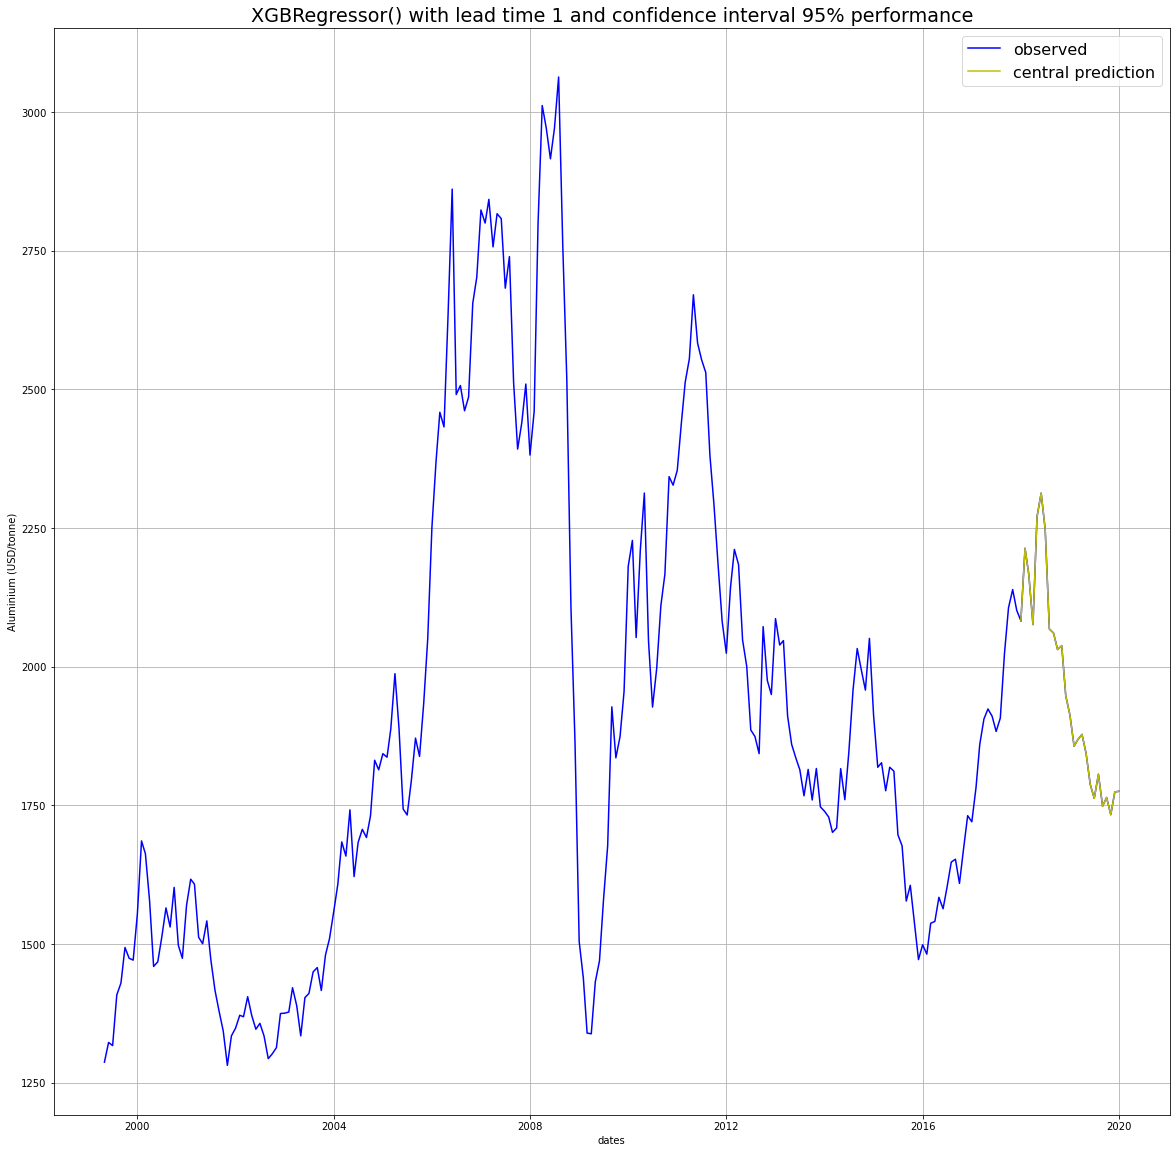

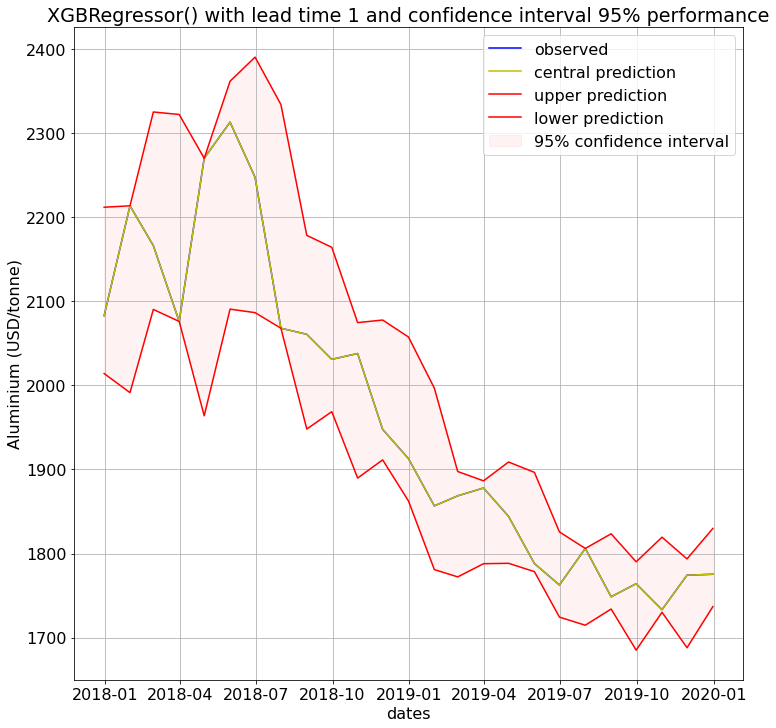

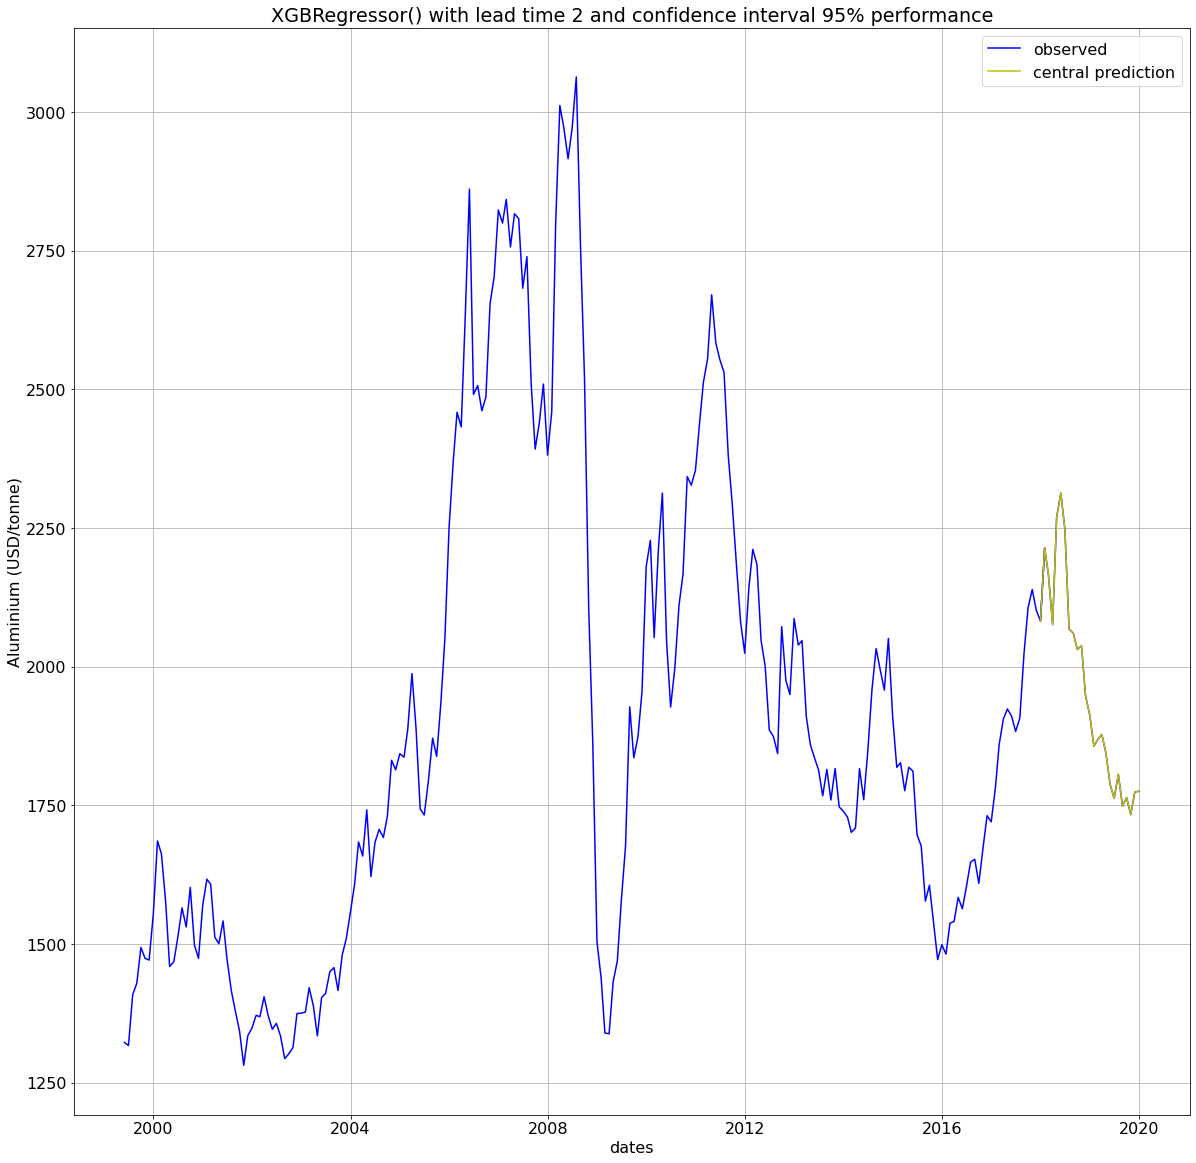

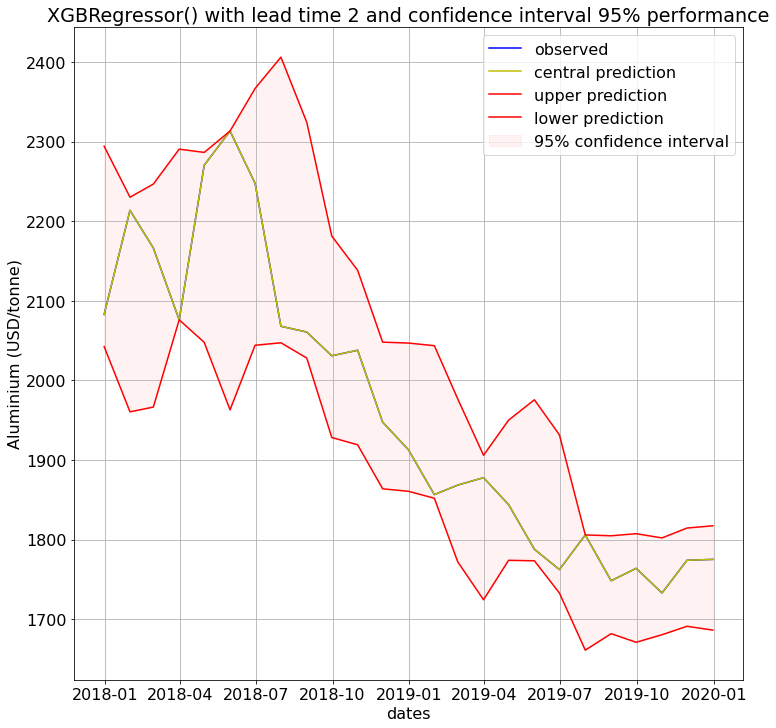

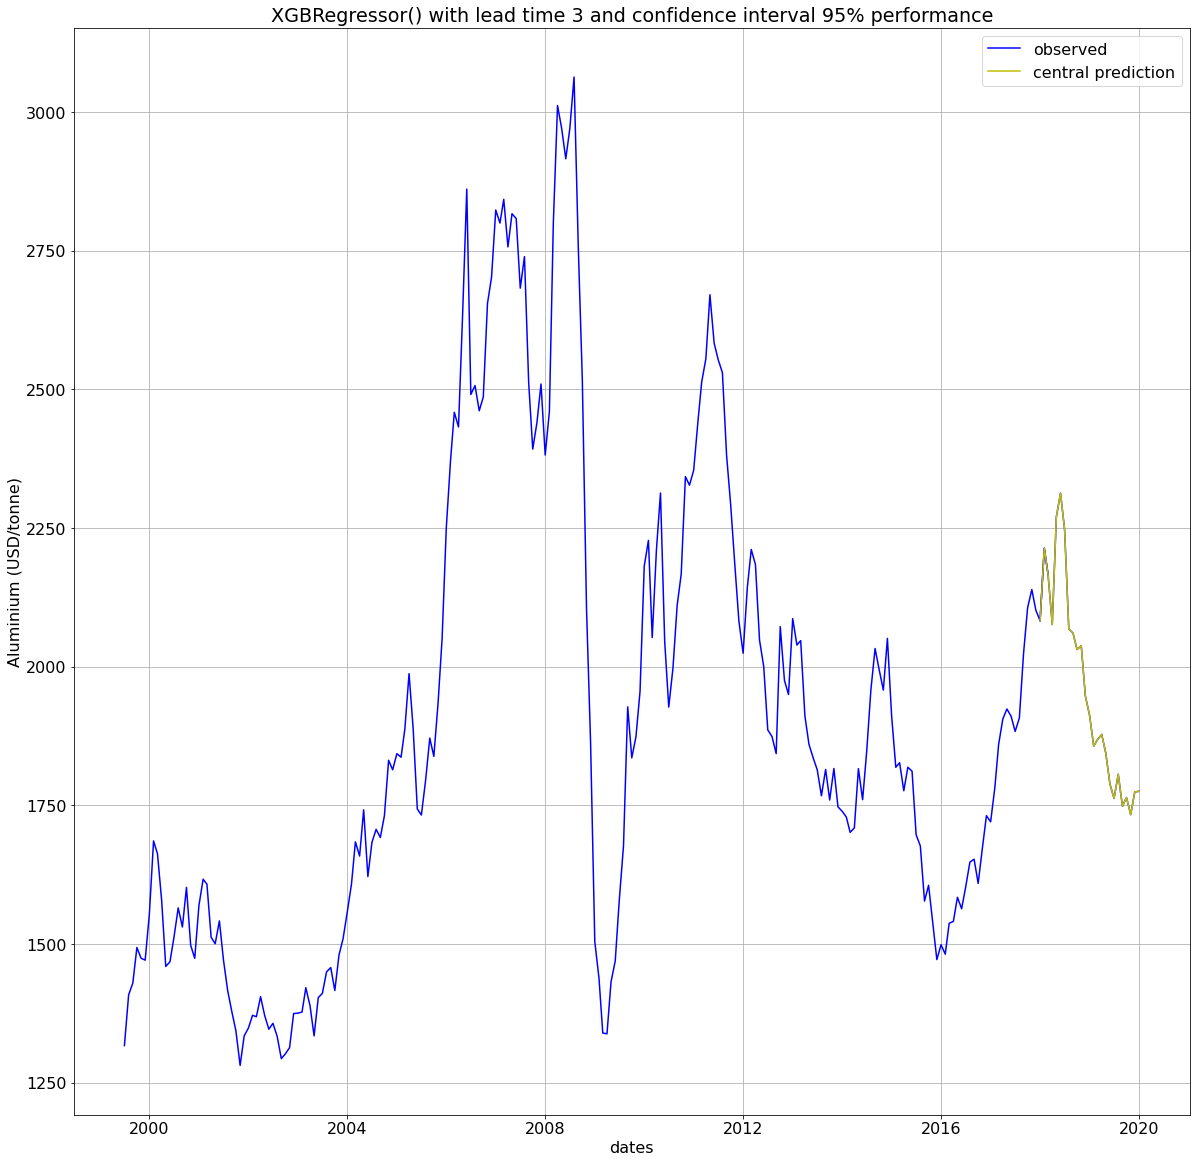

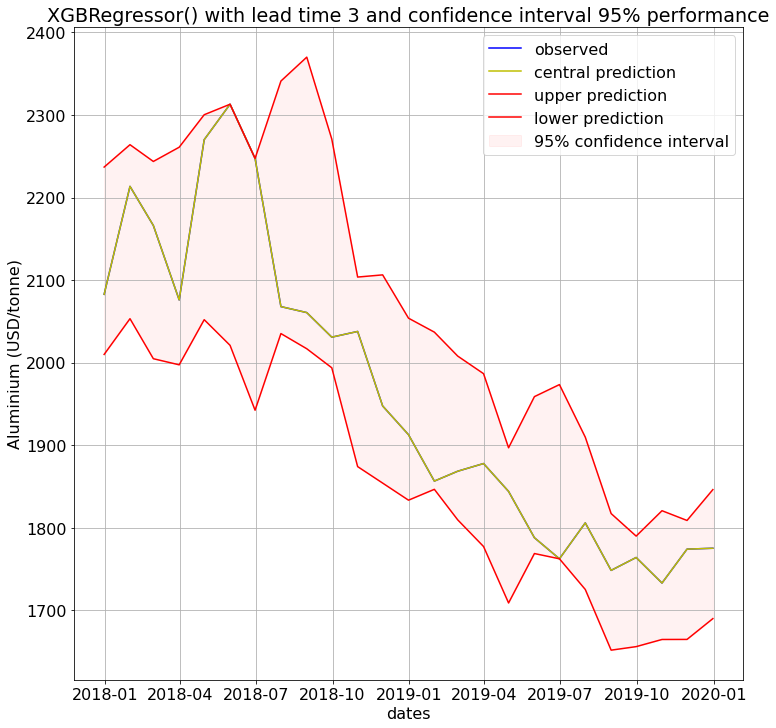

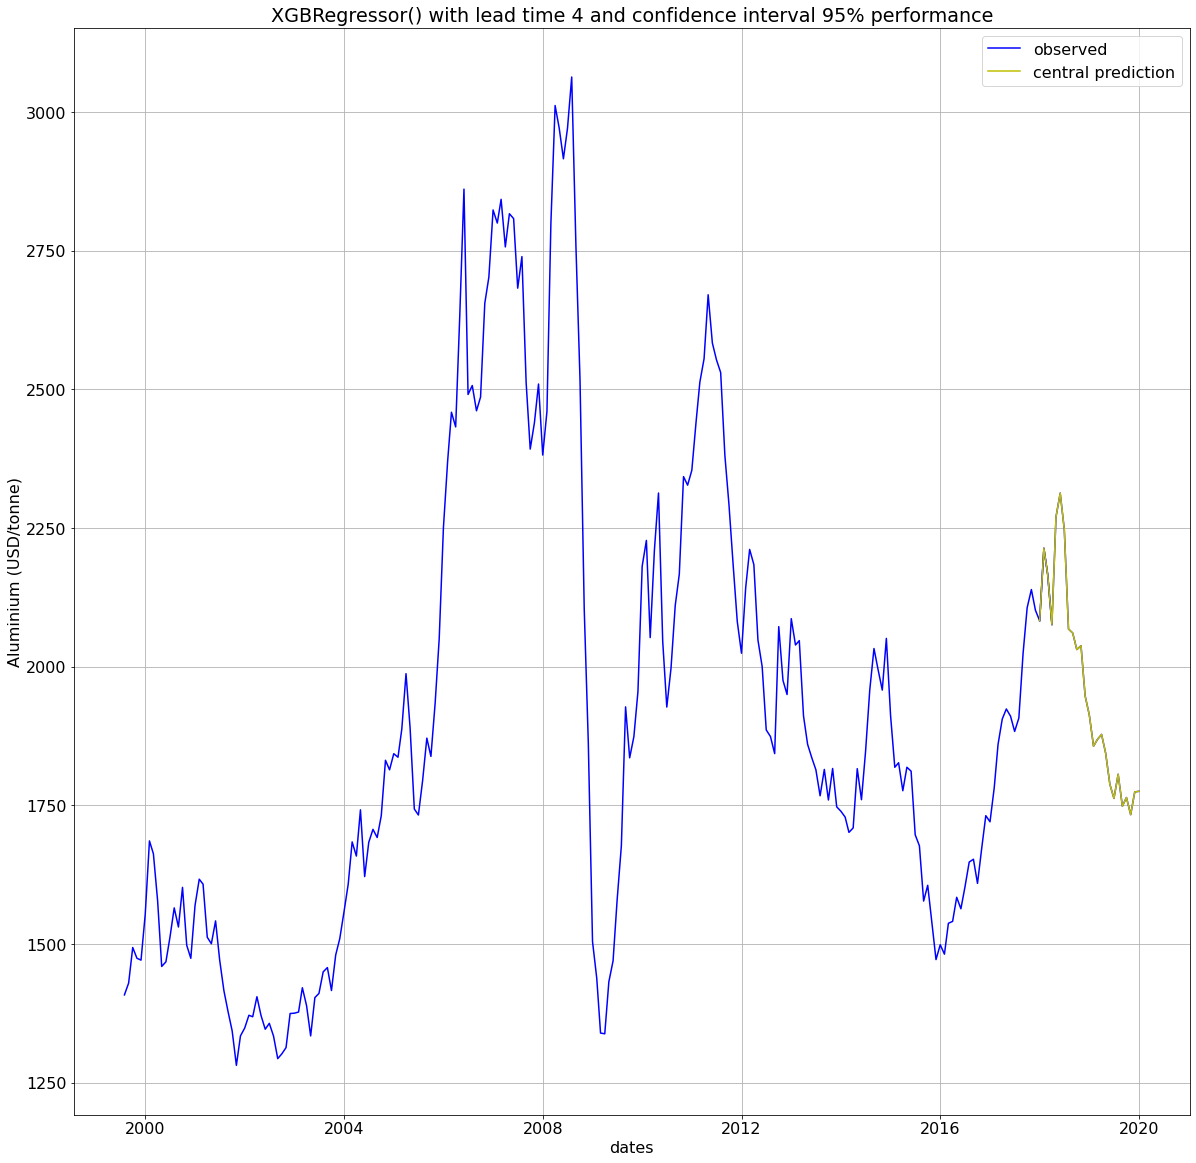

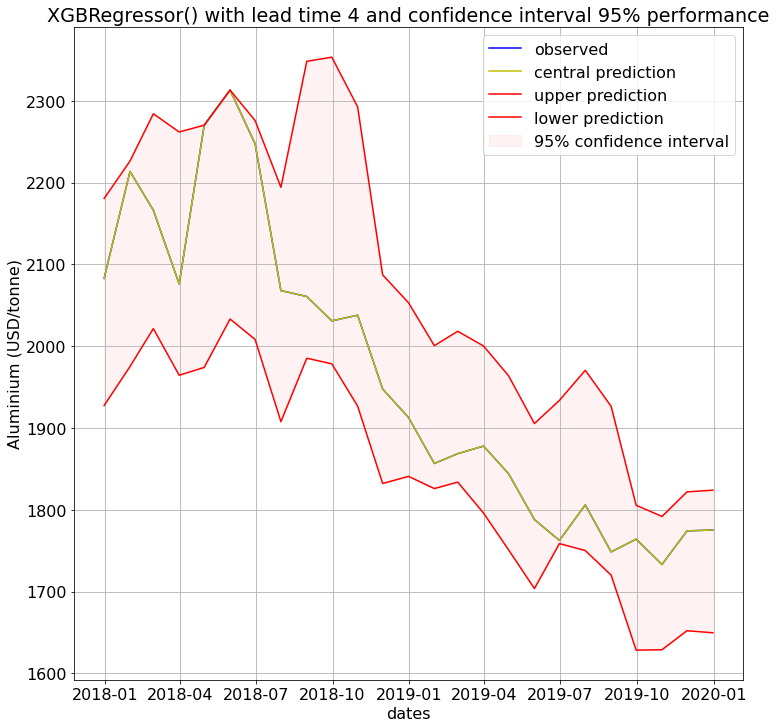

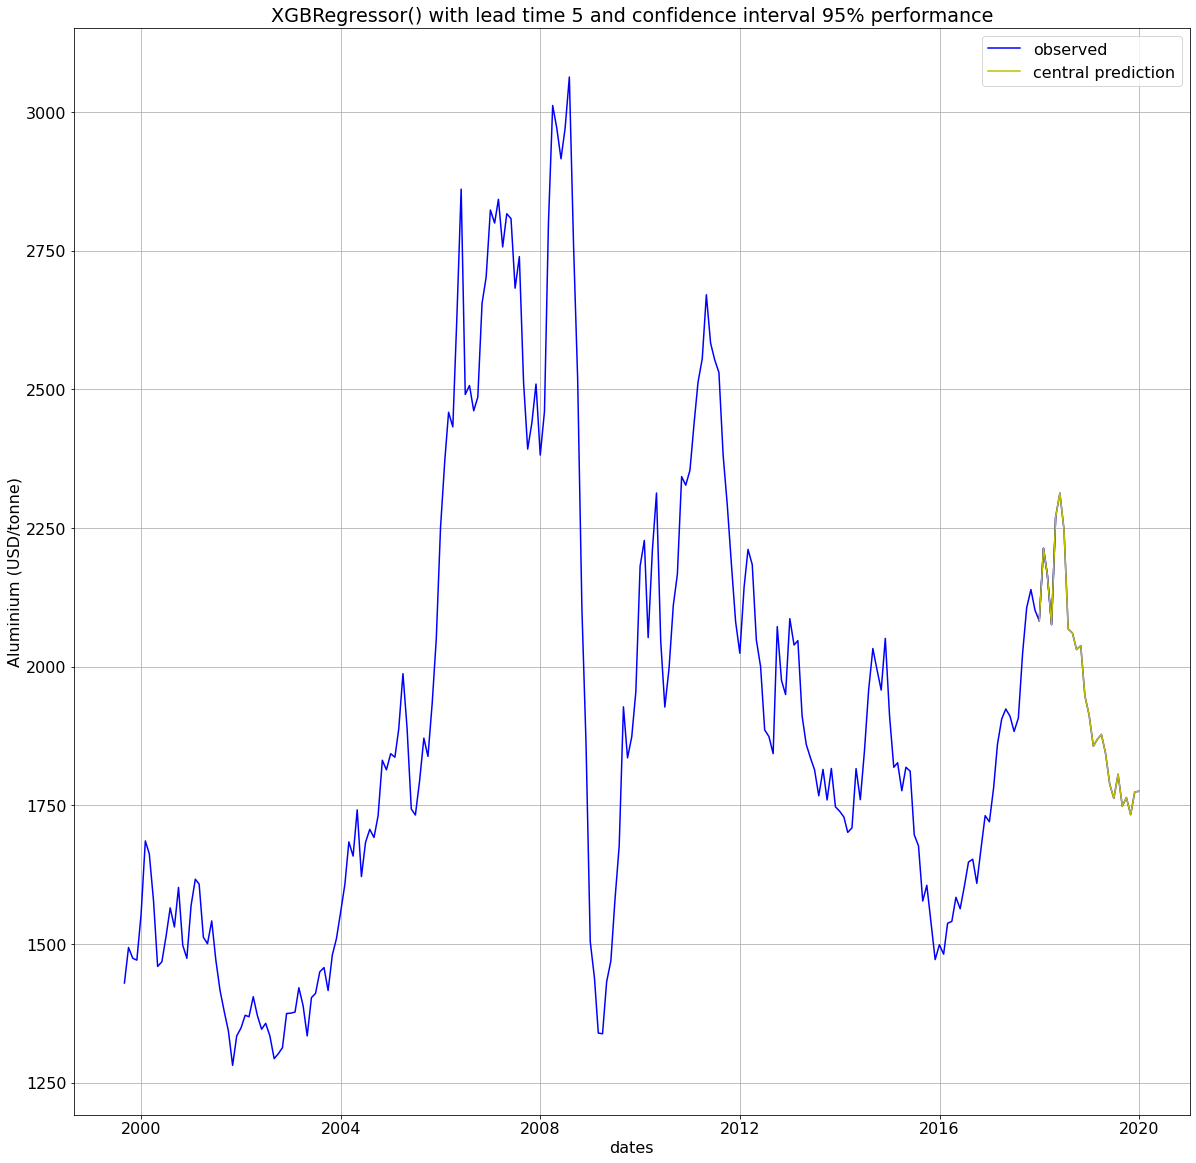

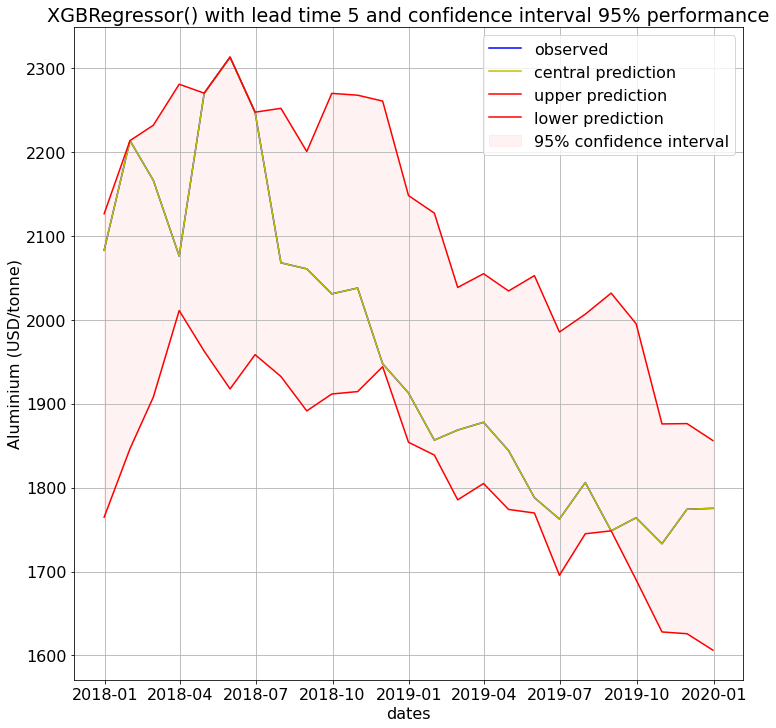

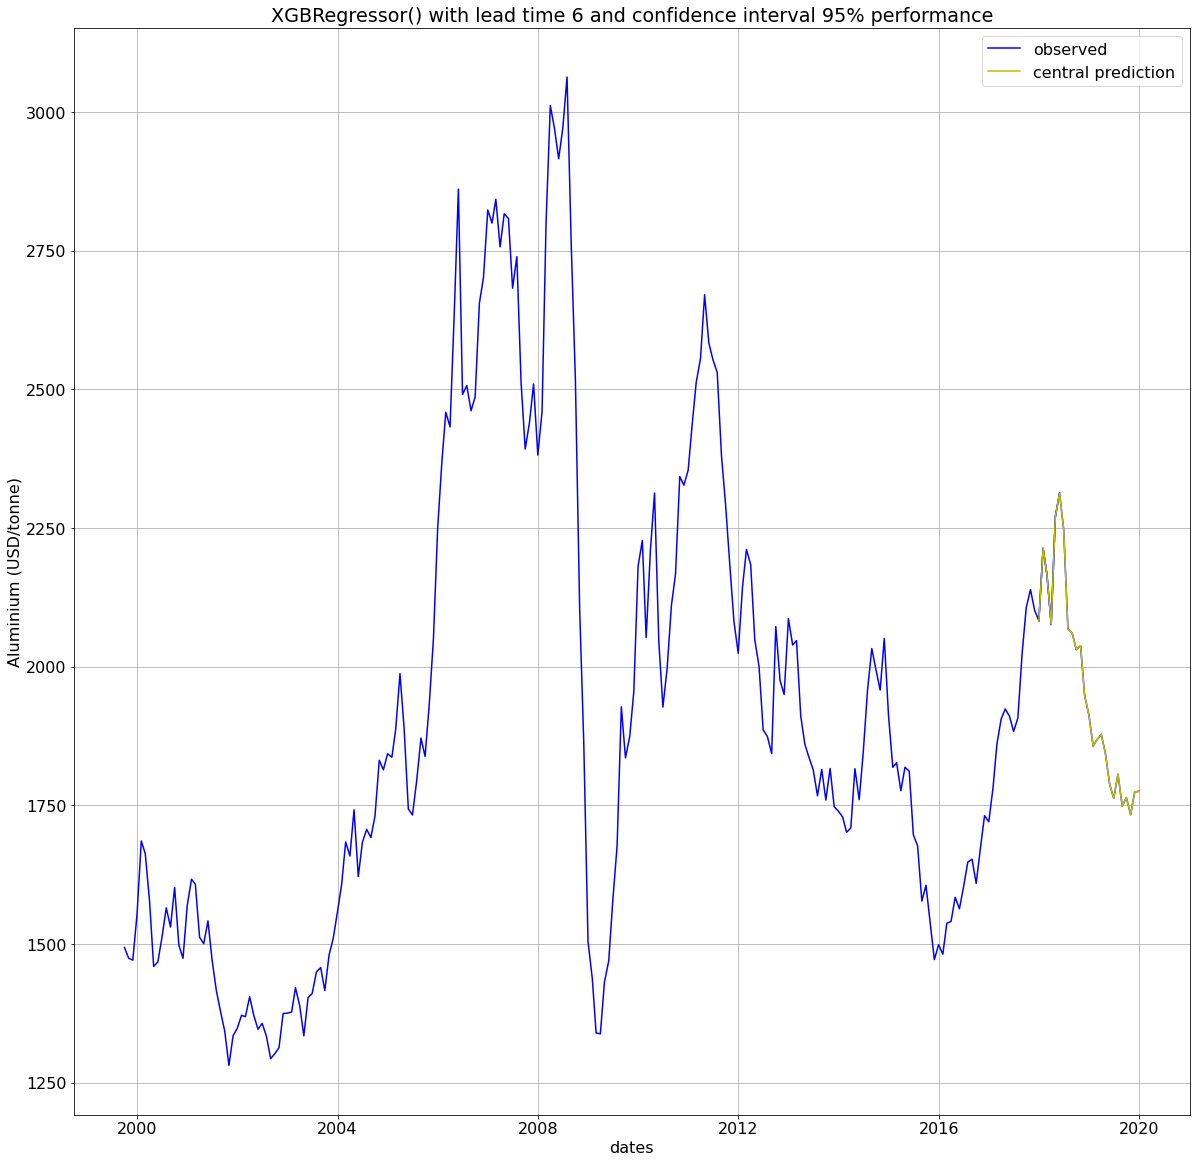

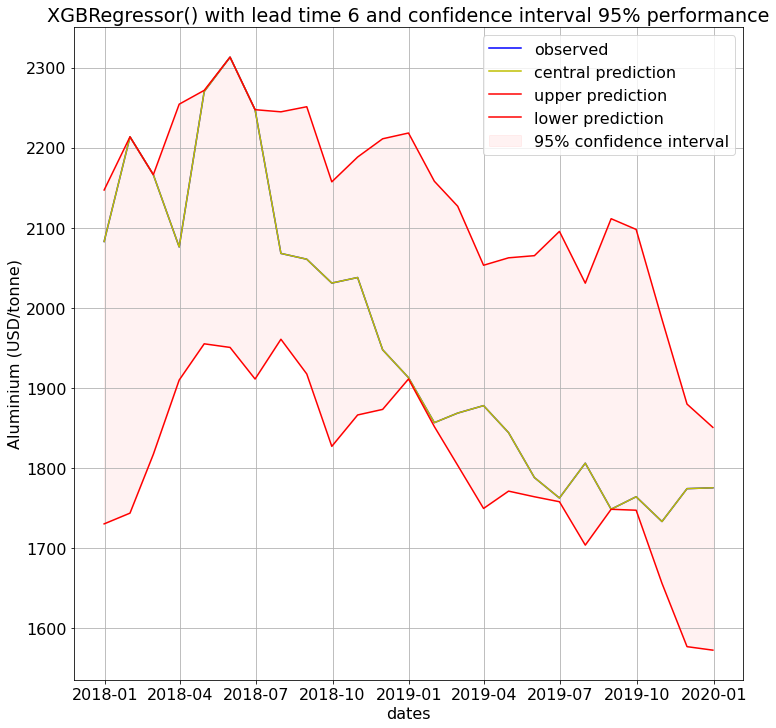

ValueError: Found array with 0 feature(s) (shape=(225, 0)) while a minimum of 1 is required by StandardScaler.

In [39]:
predictions_df = pd.DataFrame()

for model_type in model_types:
    for vars_index, lead_time in enumerate(lead_times):
        best_vars_used = best_vars[vars_index]
        for confidence_interval in confidence_intervals:

            results, predictions, y_test = model_run(lagged_df=lagged_df, 
                                                     model_type=model_type, 
                                                     best_vars=best_vars_used, 
                                                     lead_time=lead_time, 
                                                     target_var=target_var,
                                                     confidence=confidence_interval,
                                                     boot=1000, 
                                                     test_ratio=0.1
                                                    )
            # plot results
#             print(results)
            plot_model_performance(lagged_df, results, y_test, target_var, results_path)
            zoomed_model_performance(results, y_test, target_var, results_path)
            
            predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Multivariate ML Model results ALUMINIUM - monthly resolution.xlsx', index=False)
predictions_df

### 2. target variable is 'Copper (USD/pound)'

ML models

In [ ]:
target_var = 'Copper (USD/tonne)'

In [ ]:
lagged_df = lagged_df_func(df, target_var, min_lag=1, max_lag=70)
lagged_df.dropna(inplace=True)
lagged_df

In [ ]:
results_path = r'C:\Users\atorolopoulos\Desktop\Python\Results\ML Multivariate\Copper'

model_types = ['XGBRegressor()', 'RandomForestRegressor()', 
                'KNeighborsRegressor()', 'MLPRegressor()']

lead_times = [1, 2, 3, 6, 12]

confidence_intervals = [0.95]
# confidence_intervals = [0.95]

best_vars = choose_best_vars(lagged_df, lead_times, target_var, results_path, thr = 0.4)  # keep best vars univariate
best_vars

In [ ]:
predictions_df = pd.DataFrame()

for model_type in model_types:
    for vars_index, lead_time in enumerate(lead_times):
        best_vars_used = best_vars[vars_index]
        for confidence_interval in confidence_intervals:

            results, predictions, y_test = model_run(lagged_df=lagged_df, 
                                                     model_type=model_type, 
                                                     best_vars=best_vars_used, 
                                                     lead_time=lead_time, 
                                                     target_var=target_var,
                                                     confidence=confidence_interval,
                                                     boot=1000, 
                                                     test_ratio=0.1
                                                    )
            # plot results
#             print(results)
            plot_model_performance(lagged_df, results, y_test, target_var, results_path)
            zoomed_model_performance(results, y_test, target_var, results_path)
            
            predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Multivariate ML Model results COPPER - monthly resolution.xlsx', index=False)
predictions_df

### 2. target variable is 'Zinc (USD/tonne)'

ML models

In [ ]:
target_var = 'Zinc (USD/tonne)'

In [ ]:
lagged_df = lagged_df_func(df, target_var, min_lag=1, max_lag=50)
lagged_df.dropna(inplace=True)
lagged_df

In [ ]:
results_path = r'C:\Users\atorolopoulos\Desktop\Python\Results\ML Multivariate\Zinc'

model_types = ['XGBRegressor()', 'RandomForestRegressor()', 'LinearRegression()', 
               'Ridge()', 'SVR()', 'KNeighborsRegressor()', 'MLPRegressor()']

lead_times = [1, 2, 3, 6, 12]

confidence_intervals = [0.95]
# confidence_intervals = [0.95]

best_vars = choose_best_vars(lagged_df, lead_times, target_var, results_path, thr = 0.4)  # keep best vars univariate
best_vars

In [ ]:
predictions_df = pd.DataFrame()

for model_type in model_types:
    for vars_index, lead_time in enumerate(lead_times):
        best_vars_used = best_vars[vars_index]
        for confidence_interval in confidence_intervals:

            results, predictions, y_test = model_run(lagged_df=lagged_df, 
                                                     model_type=model_type, 
                                                     best_vars=best_vars_used, 
                                                     lead_time=lead_time, 
                                                     target_var=target_var,
                                                     confidence=confidence_interval,
                                                     boot=1000, 
                                                     test_ratio=0.1
                                                    )
            # plot results
#             print(results)
            plot_model_performance(lagged_df, results, y_test, target_var, results_path)
            zoomed_model_performance(results, y_test, target_var, results_path)
            
            predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Multivariate ML Model results ZINC - monthly resolution.xlsx', index=False)
predictions_df